<a href="https://colab.research.google.com/github/a00377571/IBM-Python101/blob/main/A2c_DL_AlexNet_VGG_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [7]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [4]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/cifar-10/cifar-10-batches-py'
DATA_PATH = '/home/pepe/Documents/github_repos/datasets/cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

100%|██████████| 170498071/170498071 [00:03<00:00, 48436673.39it/s]


Extracting /home/pepe/Documents/github_repos/datasets/cifar-10-batches-py/cifar-10-python.tar.gz to /home/pepe/Documents/github_repos/datasets/cifar-10-batches-py
Files already downloaded and verified
Files already downloaded and verified


In [8]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### Usar GPU

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


### Mostrar imágenes

La imagen muestreada representa un: Ship


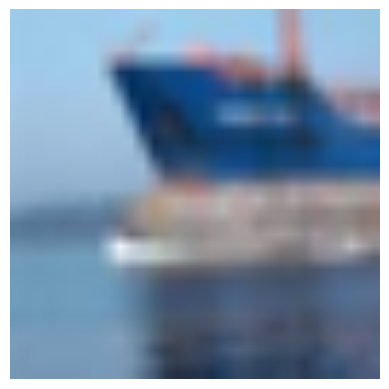

In [9]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calcular Accuracy

In [10]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total



### Cargar modelo pre-cargado

In [148]:
model_resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


#### Exploremos el modelo

In [149]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [151]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

In [152]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [153]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [154]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [155]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [156]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento

In [30]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [158]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [159]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [160]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 1.2958848476409912, accuracy: 0.7788,
Epoch: 1, costo: 0.8260197043418884, accuracy: 0.7928,
Epoch: 2, costo: 0.5658650398254395, accuracy: 0.803,


In [161]:
accuracy(model1, test_loader)

0.7951

## Sección nueva
###                 **Implementación de: "Transfeer Learning" con modelo : Alex Net.**

In [11]:
alexnet = models.alexnet(pretrained=True) #Se carga el modelo preentrenado de AlexNet.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 117MB/s]



## **Explorando el modelo de AlexNet.**



In [12]:
for i, w in enumerate(alexnet.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 11, 11]) True
1 torch.Size([64]) True
2 torch.Size([192, 64, 5, 5]) True
3 torch.Size([192]) True
4 torch.Size([384, 192, 3, 3]) True
5 torch.Size([384]) True
6 torch.Size([256, 384, 3, 3]) True
7 torch.Size([256]) True
8 torch.Size([256, 256, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([4096, 9216]) True
11 torch.Size([4096]) True
12 torch.Size([4096, 4096]) True
13 torch.Size([4096]) True
14 torch.Size([1000, 4096]) True
15 torch.Size([1000]) True


In [13]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Aquí se observa que la última línea de código (6: Linear (in_features...,out:features=1000, bias...)) del modelo AlexNet, es un modelo Fully Conected de red neural con 1000 salidas, porque fué entrenado para clasificar  las imagenes en la competencia Imaginet en 1000 clases.  
 Para nuestra aplicación en un data set de 10 clases, se requiere sólo 10 salidas por tanto procedemos a reemplezar ésta última linea del modelo: por un modelo lienal de 10 salidas**

In [14]:
model2_aux = nn.Sequential(*list(alexnet.children())) #con ello volvemos el modelo como lista iterable
model2_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
  (2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplac

In [22]:
model2_aux = nn.Sequential(*list(alexnet.children())[:-1])
model2_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
)

In [23]:
# Se congelan los parámetros del modelo.
for i, parameter in enumerate(model2_aux.parameters()):
    parameter.requires_grad = False

In [24]:
#Se imprimen para comprobar que están congelados.
for i, parameter in enumerate(model2_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False


In [47]:
lr = 1e-4 #--------------------OJO estaba en 5e-4-----------
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model2= nn.Sequential(model2_aux,
                       nn.Dropout(p=0.5, inplace=False),
                       nn.Flatten(),
                       nn.Linear(in_features=9216, out_features=4096, bias= True),
                       nn.ReLU(inplace=True),
                       nn.Dropout(p=0.5, inplace=False),
                       nn.Linear(in_features=4096, out_features=1024),
                       nn.ReLU(inplace=True),
                       nn.Linear(in_features=1024, out_features=10, bias= True),
                      )
optimiser = torch.optim.Adam(model2_aux.parameters(), lr=lr, betas=(0.9, 0.999))


In [45]:
model2

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (1): Dropout(p=0.5, inplace=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Lin

In [46]:
# Etapa de entrenamiento.
train(model2, optimiser, epochs)

KeyboardInterrupt: 

## **Implementación de: "Transfer Learning" con el modelo VGG 16**

In [33]:
vgg = models.vgg11(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:19<00:00, 26.9MB/s]


In [34]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 


## **Explorando el modelo de VGG 11.**



In [35]:
for i, w in enumerate(vgg.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 3, 3]) True
1 torch.Size([64]) True
2 torch.Size([128, 64, 3, 3]) True
3 torch.Size([128]) True
4 torch.Size([256, 128, 3, 3]) True
5 torch.Size([256]) True
6 torch.Size([256, 256, 3, 3]) True
7 torch.Size([256]) True
8 torch.Size([512, 256, 3, 3]) True
9 torch.Size([512]) True
10 torch.Size([512, 512, 3, 3]) True
11 torch.Size([512]) True
12 torch.Size([512, 512, 3, 3]) True
13 torch.Size([512]) True
14 torch.Size([512, 512, 3, 3]) True
15 torch.Size([512]) True
16 torch.Size([4096, 25088]) True
17 torch.Size([4096]) True
18 torch.Size([4096, 4096]) True
19 torch.Size([4096]) True
20 torch.Size([1000, 4096]) True
21 torch.Size([1000]) True


In [36]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

**Aquí se observa que la última línea de código (6: Linear (in_features...,out:features=1000, bias...)) del modelo VGG, es un modelo Fully Conected de red neural con 1000 salidas, porque fué entrenado para clasificar  las imagenes en la competencia Imaginet en 1000 clases.  
 Para nuestra aplicación en un data set de 10 clases, se requiere sólo 10 salidas por tanto procedemos a reemplezar ésta última linea del modelo: por un modelo lienal de 10 salidas**

In [37]:
model3_aux = nn.Sequential(*list(vgg.children())) #con ello volvemos el modelo como lista iterable
model3_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [38]:
model3_aux = nn.Sequential(*list(alexnet.children())[:-1])
model3_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
)

In [39]:
# Se congelan los parámetros del modelo.
for i, parameter in enumerate(model3_aux.parameters()):
    parameter.requires_grad = False

In [40]:
#Se imprimen para comprobar que están congelados.
for i, parameter in enumerate(model3_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False


In [49]:
lr = 1e-4       #--------------------ojo estaba en 5e-4-----------
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model3= nn.Sequential(model3_aux,
                       nn.Dropout(p=0.5, inplace=False),
                       nn.Flatten(),
                       nn.Linear(in_features=9216, out_features=4096, bias= True),
                       nn.ReLU(inplace=True),
                       nn.Dropout(p=0.5, inplace=False),
                       nn.Linear(in_features=4096, out_features=1024),
                       nn.ReLU(inplace=True),
                       nn.Linear(in_features=1024, out_features=10, bias= True),
                      )
optimiser = torch.optim.Adam(model3_aux.parameters(), lr=lr, betas=(0.9, 0.999))


In [50]:
model3

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (1): Dropout(p=0.5, inplace=False)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Lin

In [51]:
# Etapa de entrenamiento.
train(model3, optimiser, epochs)

KeyboardInterrupt: 